# Forecasting solar flares using neural networks for classification
***


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score)
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load raw dataframe
df = pd.read_csv("../data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        4480 non-null   object 
 1   USFLUX                      4480 non-null   float64
 2   MEANGAM                     4480 non-null   float64
 3   MEANGBT                     4480 non-null   float64
 4   MEANGBZ                     4480 non-null   float64
 5   MEANGBH                     4480 non-null   float64
 6   MEANJZD                     4480 non-null   float64
 7   TOTUSJZ                     4480 non-null   float64
 8   MEANALP                     4480 non-null   float64
 9   MEANJZH                     4480 non-null   float64
 10  TOTUSJH                     4480 non-null   float64
 11  ABSNJZH                     4480 non-null   float64
 12  SAVNCPP                     4480 non-null   float64
 13  MEANPOT                     4480 

# Changing the dataframe to fit NN
***

In [3]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64         

In [4]:
# Analyze flare distribution over time

# Number of flare-days per year
df_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum'])
print(df_flares)

        sum
DATE       
2010    8.0
2011   65.0
2012   79.0
2013   68.0
2014  118.0
2015   68.0
2016   11.0
2017   15.0
2018    0.0
2019    0.0
2020    2.0
2021   21.0
2022   92.0
2023    8.0


In [5]:
# Number of days with flares (count should be 8760 [24*365] or 8784 for leap years)
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count'])
print("\nDays with flare distribution by year:")
print(yearly_flares)


Days with flare distribution by year:
        sum  count
DATE              
2010    8.0    245
2011   65.0    365
2012   79.0    366
2013   68.0    365
2014  118.0    365
2015   68.0    365
2016   11.0    366
2017   15.0    365
2018    0.0    345
2019    0.0    273
2020    2.0    317
2021   21.0    365
2022   92.0    365
2023    8.0     13


In [6]:
def create_lagged_features(df, n_days=3):
    """
    Create features using the last n_days of data to predict the next day's flare.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').reset_index(drop=True)
    
    # Features to use (exclude DATE and target)
    feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today']]
    
    # Create lagged features for each of the past n_days
    lagged_df = pd.DataFrame(index=df.index) # important to keep the index for alignment
    
    for i in range(1, n_days + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: next day's flare (shift flare_today by -1)
    lagged_df['target'] = df['flare_today'].shift(-1)
    lagged_df['DATE'] = df['DATE']
    
    # Drop rows with NaN (first n_days rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [7]:
# Create the lagged features for the past 3 days
lagged_data = create_lagged_features(df, n_days=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4476 entries, 3 to 4478
Data columns (total 95 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   USFLUX_lag1                      4476 non-null   float64            
 1   MEANGAM_lag1                     4476 non-null   float64            
 2   MEANGBT_lag1                     4476 non-null   float64            
 3   MEANGBZ_lag1                     4476 non-null   float64            
 4   MEANGBH_lag1                     4476 non-null   float64            
 5   MEANJZD_lag1                     4476 non-null   float64            
 6   TOTUSJZ_lag1                     4476 non-null   float64            
 7   MEANALP_lag1                     4476 non-null   float64            
 8   MEANJZH_lag1                     4476 non-null   float64            
 9   TOTUSJH_lag1                     4476 non-null   float64            
 10  ABSNJ

In [8]:
# The dataset is too big to run the hyperparameter opitmization in my PC, so I am going to use a sample for this part
lagged_data_short = lagged_data.sample(frac=0.10)
print(lagged_data_short.info())

<class 'pandas.core.frame.DataFrame'>
Index: 448 entries, 1941 to 4140
Data columns (total 95 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   USFLUX_lag1                      448 non-null    float64            
 1   MEANGAM_lag1                     448 non-null    float64            
 2   MEANGBT_lag1                     448 non-null    float64            
 3   MEANGBZ_lag1                     448 non-null    float64            
 4   MEANGBH_lag1                     448 non-null    float64            
 5   MEANJZD_lag1                     448 non-null    float64            
 6   TOTUSJZ_lag1                     448 non-null    float64            
 7   MEANALP_lag1                     448 non-null    float64            
 8   MEANJZH_lag1                     448 non-null    float64            
 9   TOTUSJH_lag1                     448 non-null    float64            
 10  ABS

In [9]:
# chronological split is important for time series
lagged_data_short = lagged_data_short.sort_values('DATE').reset_index(drop=True)
assert lagged_data_short['DATE'].is_monotonic_increasing

print(lagged_data_short.head())

    USFLUX_lag1  MEANGAM_lag1  MEANGBT_lag1  MEANGBZ_lag1  MEANGBH_lag1  \
0  2.737004e+21     32.654695    114.207593    116.857353     50.317212   
1  2.278838e+21     29.397792    111.948976    112.256818     45.044785   
2  7.602594e+21     33.620393     96.835604    107.787652     46.203977   
3  5.121139e+21     35.370675    128.746375    127.877142     58.289100   
4  3.498267e+21     26.974470     98.163724     97.903041     36.790078   

   MEANJZD_lag1  TOTUSJZ_lag1  MEANALP_lag1  MEANJZH_lag1  TOTUSJH_lag1  ...  \
0      0.219577  3.095129e+12     -0.002852     -0.000701    147.333590  ...   
1      0.218362  2.226788e+12     -0.008169     -0.002089    109.022879  ...   
2     -0.290930  9.054637e+12      0.000628      0.000280    502.313662  ...   
3      0.030781  7.336856e+12     -0.019546     -0.006867    353.820858  ...   
4     -0.222156  3.638927e+12     -0.003655     -0.001504    167.051060  ...   

   Radio Flux 10.7cm_lag3  Sunspot Number_lag3  \
0                 

In [10]:
# let's check all columns to drop some on the next step
print(lagged_data_short.columns)

Index(['USFLUX_lag1', 'MEANGAM_lag1', 'MEANGBT_lag1', 'MEANGBZ_lag1',
       'MEANGBH_lag1', 'MEANJZD_lag1', 'TOTUSJZ_lag1', 'MEANALP_lag1',
       'MEANJZH_lag1', 'TOTUSJH_lag1', 'ABSNJZH_lag1', 'SAVNCPP_lag1',
       'MEANPOT_lag1', 'TOTPOT_lag1', 'MEANSHR_lag1', 'SHRGT45_lag1',
       'R_VALUE_lag1', 'xrs_A_mean_lag1', 'xrs_A_min_lag1', 'xrs_A_max_lag1',
       'xrs_B_mean_lag1', 'xrs_B_min_lag1', 'xrs_B_max_lag1',
       'Radio Flux 10.7cm_lag1', 'Sunspot Number_lag1',
       'Sunspot Area (10^6 Hemis.)_lag1', 'New Regions_lag1', 'Flares: C_lag1',
       'Flares: M_lag1', 'Flares: X_lag1', 'flare_missing_lag1', 'USFLUX_lag2',
       'MEANGAM_lag2', 'MEANGBT_lag2', 'MEANGBZ_lag2', 'MEANGBH_lag2',
       'MEANJZD_lag2', 'TOTUSJZ_lag2', 'MEANALP_lag2', 'MEANJZH_lag2',
       'TOTUSJH_lag2', 'ABSNJZH_lag2', 'SAVNCPP_lag2', 'MEANPOT_lag2',
       'TOTPOT_lag2', 'MEANSHR_lag2', 'SHRGT45_lag2', 'R_VALUE_lag2',
       'xrs_A_mean_lag2', 'xrs_A_min_lag2', 'xrs_A_max_lag2',
       'xrs_B_mea

# Fitting the model
***

In [11]:
# Separate features and target
# I started using the DST feature, and it is be very useful, but it is not always available in real-time forecasts
#X = lagged_data_short.drop(['DATE', 'target', 'DST_lag1', 'DST_lag2', 'DST_lag3'], axis=1)
X = lagged_data_short.drop(['DATE', 'target'], axis=1)
y = lagged_data_short['target']

print(X.info(), y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 93 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   USFLUX_lag1                      448 non-null    float64
 1   MEANGAM_lag1                     448 non-null    float64
 2   MEANGBT_lag1                     448 non-null    float64
 3   MEANGBZ_lag1                     448 non-null    float64
 4   MEANGBH_lag1                     448 non-null    float64
 5   MEANJZD_lag1                     448 non-null    float64
 6   TOTUSJZ_lag1                     448 non-null    float64
 7   MEANALP_lag1                     448 non-null    float64
 8   MEANJZH_lag1                     448 non-null    float64
 9   TOTUSJH_lag1                     448 non-null    float64
 10  ABSNJZH_lag1                     448 non-null    float64
 11  SAVNCPP_lag1                     448 non-null    float64
 12  MEANPOT_lag1          

In [12]:
# Split into train and test sets

# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 358
Test samples: 90

Class distribution in training set:
target
0.0    307
1.0     51
Name: count, dtype: int64
Percentage of positive cases in train: 14.25%

Class distribution in test set:
target
0.0    77
1.0    13
Name: count, dtype: int64
Percentage of positive cases in test: 14.44%


In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Apply SMOTE to balance the training data
#smote = SMOTE(random_state=42)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

#print(f"\nAfter SMOTE:")
#print(f"Training samples: {len(X_train_balanced)}")
#print(pd.Series(y_train_balanced).value_counts())

In [15]:
# you can just load the model if already trained and not run the grid search and best model again
# in that case, do not run the next two cells
model = load_model('../data/flares_keras.keras')

In [16]:
def create_model(n_features, layer1_units=128, layer2_units=64, 
                 dropout_rate=0.3, learning_rate=0.001):
    """Create model with configurable hyperparameters"""
    model = Sequential([
        Input(shape=(n_features,)),
        Dense(layer1_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(layer2_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['Precision', 'Recall', 'AUC']
    )
    
    return model

In [17]:
def randomized_search(X_train_scaled, y_train, n_iter=20):
    """Random search over hyperparameters"""
    
    # Define hyperparameter ranges
    param_distributions = {
        'layer1_units': [64, 128, 256, 512],
        'layer2_units': [32, 64, 128, 256],
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
        'batch_size': [16, 32, 64, 128]
    }
    
    n_features = X_train_scaled.shape[1]
    
    # Compute class weights once
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )))
    
    best_score = 0
    best_params = {}
    results = []
    
    print(f"Testing {n_iter} random combinations...")
    
    for i in range(n_iter):
        # Random sample from each parameter
        params = {
            'layer1_units': np.random.choice(param_distributions['layer1_units']),
            'layer2_units': np.random.choice(param_distributions['layer2_units']),
            'dropout_rate': np.random.choice(param_distributions['dropout_rate']),
            'learning_rate': np.random.choice(param_distributions['learning_rate']),
            'batch_size': np.random.choice(param_distributions['batch_size'])
        }
        
        print(f"\n[{i+1}/{n_iter}] Testing: {params}")
        
        # Create model (exclude batch_size from model creation)
        model_params = {k: v for k, v in params.items() if k != 'batch_size'}
        model = create_model(n_features=n_features, **model_params)
        
        es = EarlyStopping(patience=10, restore_best_weights=True)
        history = model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=params['batch_size'],
            callbacks=[es],
            verbose=0,
            class_weight=class_weights
        )
        
        # Get best validation AUC
        val_auc = max(history.history['val_AUC'])
        print(f"  -> Val AUC: {val_auc:.4f}")
        
        # Store results
        results.append({**params, 'val_auc': val_auc})
        
        # Update best
        if val_auc > best_score:
            best_score = val_auc
            best_params = params
    
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"  Best Validation AUC: {best_score:.4f}")
    
    return best_params, best_score, results

In [18]:
# Search for the best hyperparameters
best_params, best_score, results = randomized_search(
    X_train_scaled, 
    y_train, 
    n_iter=50
)

Testing 50 random combinations...

[1/50] Testing: {'layer1_units': 64, 'layer2_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}
  -> Val AUC: 0.5211

[2/50] Testing: {'layer1_units': 128, 'layer2_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.005, 'batch_size': 128}
  -> Val AUC: 0.8803

[3/50] Testing: {'layer1_units': 128, 'layer2_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 16}
  -> Val AUC: 0.3803

[4/50] Testing: {'layer1_units': 256, 'layer2_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0005, 'batch_size': 32}
  -> Val AUC: 0.1831

[5/50] Testing: {'layer1_units': 64, 'layer2_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.005, 'batch_size': 32}
  -> Val AUC: 0.8592

[6/50] Testing: {'layer1_units': 128, 'layer2_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'batch_size': 32}
  -> Val AUC: 0.3521

[7/50] Testing: {'layer1_units': 512, 'layer2_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.005, 

In [19]:
# Get number of features
n_features = X_train_scaled.shape[1]

# Create model with best parameters
model = Sequential([
    Input(shape=(n_features,)),
    Dense(best_params['layer1_units'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['layer2_units'], activation='relu'),
    Dense(1, activation='sigmoid')
])

In [20]:
# Compile with best learning rate
model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['Precision', 'Recall', 'AUC']
)

In [21]:
# Compute class weights
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))

In [22]:
# Train with best batch size
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=[es],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.5894 - Precision: 0.1797 - Recall: 0.7800 - loss: 0.8208 - val_AUC: 0.0986 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.5783
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8179 - Precision: 0.2816 - Recall: 0.9800 - loss: 0.5954 - val_AUC: 0.1620 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.3275
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8514 - Precision: 0.3406 - Recall: 0.9400 - loss: 0.5595 - val_AUC: 0.1761 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.2222
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8194 - Precision: 0.3415 - Recall: 0.8400 - loss: 0.5752 - val_AUC: 0.1831 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.1748
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8502 - Precision: 0.3621 - Recall: 0.8400 - loss: 0.5316 - val_AUC: 0.1338 - val_Precision: 0.0000e+00 - val_Recall: 

In [23]:
# evaluate
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

{'loss': 0.5390223860740662, 'compile_metrics': 0.29629629850387573}


In [24]:
# Save the best model
model.save("../data/flares_keras.keras")
print("Best model saved to ../data/flares_keras.keras")

Best model saved to ../data/flares_keras.keras


In [25]:
# Predict
y_pred_proba = model.predict(X_test_scaled).ravel()     # flatten probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


# Results
***

In [26]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    recall = recall_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    metrics_table = pd.DataFrame({
        'Metric': ['F2', 'F1', 'Recall', 'Avg Precision', 'ROC AUC'],
        'Score': [f2_score, f1_score, recall, avg_precision, roc_auc]
    })
    print("\nEvaluation Metrics:")
    print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_test. Metrics skipped.")


Confusion Matrix:
[[58 19]
 [ 5  8]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.75      0.83        77
         1.0       0.30      0.62      0.40        13

    accuracy                           0.73        90
   macro avg       0.61      0.68      0.61        90
weighted avg       0.83      0.73      0.77        90


Evaluation Metrics:
       Metric  Score
           F2 0.5063
           F1 0.4000
       Recall 0.6154
Avg Precision 0.4187
      ROC AUC 0.6973



Visualization saved as 'solar_flare_NN_results.png'


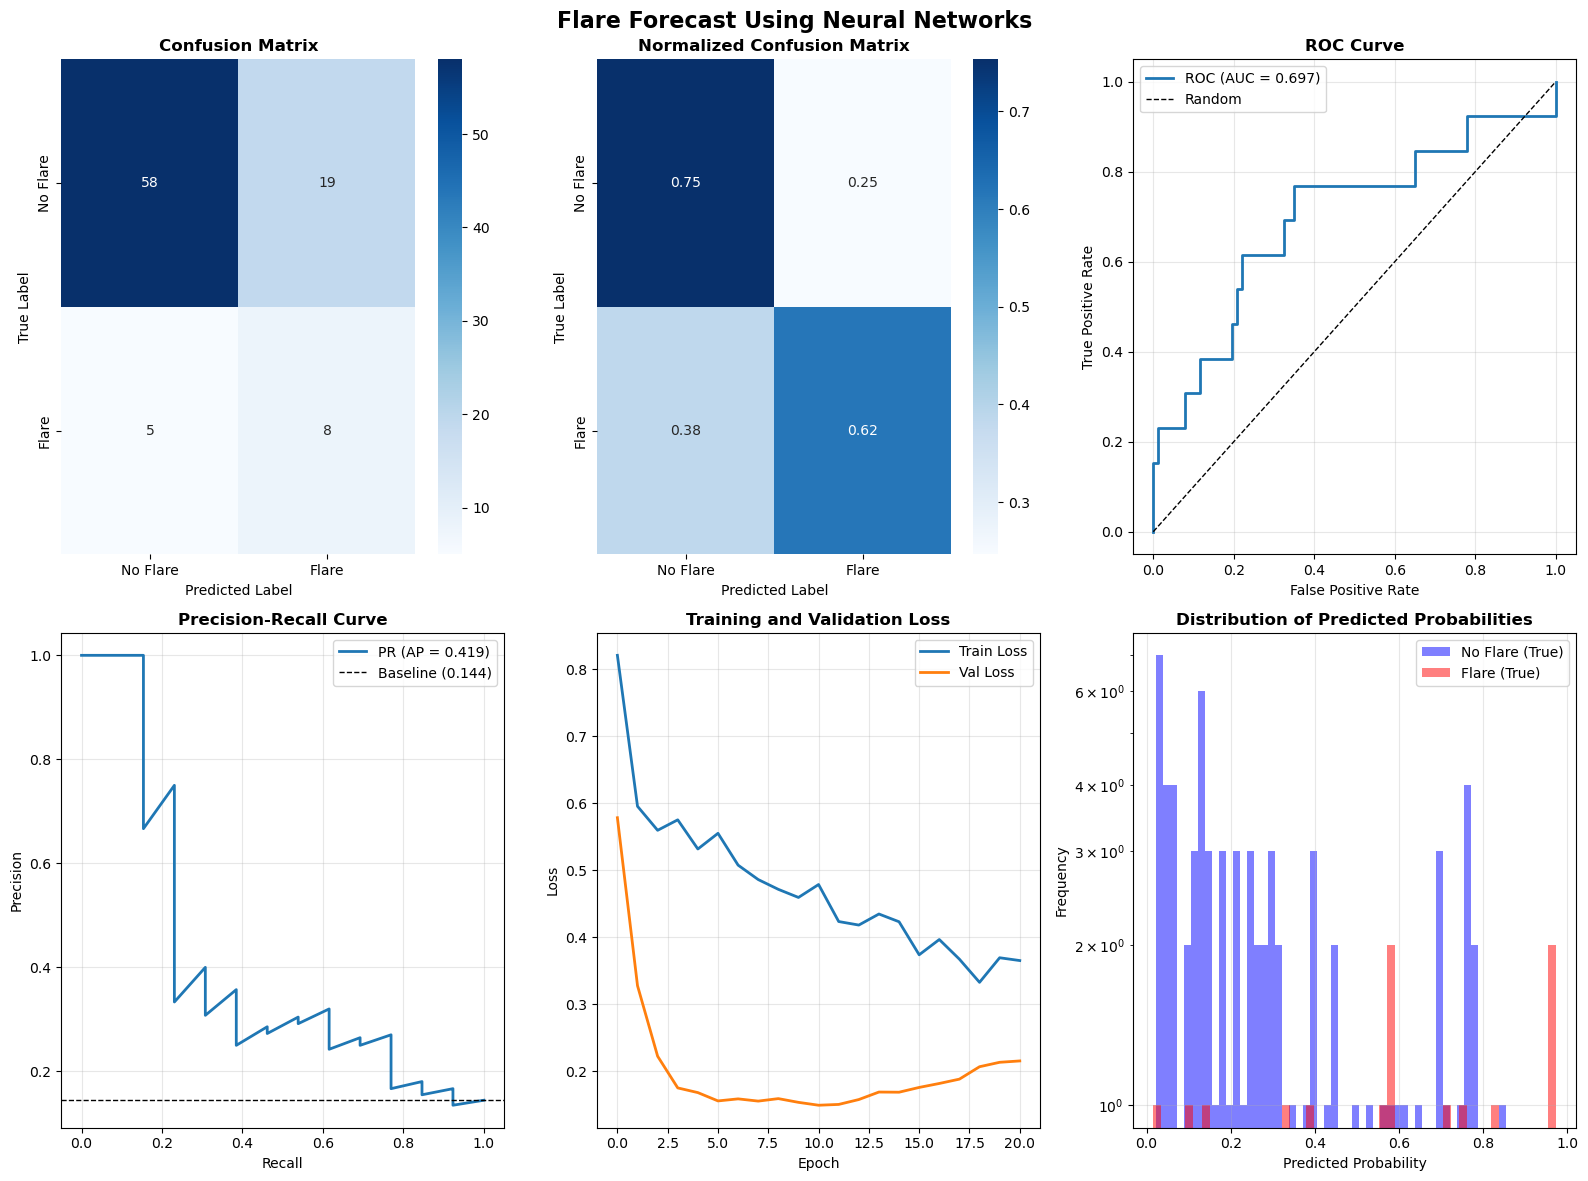

In [27]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Flare Forecast Using Neural Networks', fontsize=16, fontweight='bold')

class_names = ['No Flare', 'Flare']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax4 = plt.subplot(2, 3, 4)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax4.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Training and Validation Loss
if 'history' in locals():
    hist = history.history
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(hist['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in hist:
        ax5.plot(hist['val_loss'], label='Val Loss', linewidth=2)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 6)
ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/solar_flare_NN_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_NN_results.png'")
plt.show()

In [28]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold = 0.3
  TP: 10, FP: 30, TN: 47, FN: 3
  Precision: 0.250, Recall: 0.769

Threshold = 0.4
  TP: 8, FP: 22, TN: 55, FN: 5
  Precision: 0.267, Recall: 0.615

Threshold = 0.5
  TP: 8, FP: 19, TN: 58, FN: 5
  Precision: 0.296, Recall: 0.615

Threshold = 0.6
  TP: 5, FP: 15, TN: 62, FN: 8
  Precision: 0.250, Recall: 0.385

Threshold = 0.7
  TP: 5, FP: 10, TN: 67, FN: 8
  Precision: 0.333, Recall: 0.385
